In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle
from copy import deepcopy

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# parameters for CSTR
T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4

t_final = 0.005
t_step = 1e-4
num_step = 10
num_dims = 4

# parameters for transfer learning
seed = 0
plot = True
rng = np.random.RandomState(seed)
innerepochs = 1 # number of epochs of each inner SGD
niterations = 1000 # number of outer updates; each iteration we sample one task and update on it
ntrain = 32 # Size of training minibatches (K)
eval_step = 50 # evaluation step
threshold = 10 # threshold to check data correctness

In [ ]:
def generate_new(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_small(x):
    return x + x * np.random.uniform(-0.05, 0.05)

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def to_tensor(x):
    return tf.convert_to_tensor(x, dtype=tf.float32)

def train_on_batch(x, y, model, optimizer):
    x = to_tensor(x)
    y = to_tensor(y)

    with tf.GradientTape() as tape:
        YHat = model(x)
        loss = mse_loss_fn(y, YHat)
        grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

def predict(x, model):
    x = to_tensor(x)
    return model(x).numpy()

def compute_loss(x, y, model):
    return np.square(predict(x, model) - y).mean()

In [ ]:
def gen_task(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    isCorrect = False
    while isCorrect == False:
        T_0_new = generate_new(T_0)
        V_new = generate_new(V)
        F_new = generate_new(F)
        C_A0s_new = generate_new(C_A0s)
        Q_s_new = generate_new(Q_s)
        rho_L_new = generate_new_small(rho_L)
        C_p_new = generate_new_small(C_p)
        k_0_new = generate_new_small(k_0)
        E_new = generate_new_small(E)
        delta_H_new = generate_new_small(delta_H)

        # generating inputs and initial states for CSTR, all expressed in deviation form
        u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
        u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
        T_initial = np.linspace(300, 600, 20, endpoint=True)
        CA_initial = np.linspace(0, 6, 20, endpoint=True)

        # restruture the data
        T_start = list()
        CA_start = list()

        for T in T_initial:
            for CA in CA_initial:
                CA_start.append(CA)
                T_start.append(T)

        CA_start = np.array([CA_start])
        T_start = np.array([T_start])
        x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

        # get X and y data for training and testing
        CA_output = list()
        T_output = list()
        CA_input = list()
        T_input = list()
        CA0_input = list()
        Q_input = list()

        for u1 in u1_list:
            C_A0 = u1 + C_A0s_new
            for u2 in u2_list:
                Q = u2 + Q_s_new
                for C_A_initial, T_initial in x_deviation:

                    C_A_list, T_list = CSTR_simulation(F_new, V_new, C_A0, k_0_new, E_new, R, T_0_new, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
                    if np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                        CA0_input.append(u1)
                        Q_input.append(u2)
                        CA_input.append(C_A_initial)
                        T_input.append(T_initial)

                        CA_output.append(C_A_list)
                        T_output.append(T_list)

        # regenerate data if requirement is not met
        if len(CA_output) > ntrain:

            # collate input for RNN
            CA0_input = np.array(CA0_input)
            CA0_input = CA0_input.reshape(-1,1,1)

            Q_input = np.array(Q_input)
            Q_input = Q_input.reshape(-1,1,1)

            CA_input = np.array(CA_input)
            CA_input = CA_input.reshape(-1,1,1)

            T_input = np.array(T_input)
            T_input = T_input.reshape(-1,1,1)

            RNN_input = np.concatenate((T_input, CA_input, Q_input, CA0_input), axis=2)
            RNN_input = RNN_input.repeat(num_step, axis=1)

            # collate output for RNN
            CA_output = np.array(CA_output)
            CA_output = CA_output.reshape(-1, num_step, 1)

            T_output = np.array(T_output)
            T_output = T_output.reshape(-1, num_step, 1)

            RNN_output = np.concatenate((T_output, CA_output), axis=2)

            # scale the data
            scaler_X = preprocessing.StandardScaler().fit(RNN_input.reshape(-1, num_dims))
            scaler_y = preprocessing.StandardScaler().fit(RNN_output.reshape(-1, 2))

            X = scaler_X.transform(RNN_input.reshape(-1, num_dims))
            y = scaler_y.transform(RNN_output.reshape(-1,2))

            if np.isnan(X).any() == False and np.isnan(y).any() == False and np.isinf(X).any() == False and np.isinf(y).any() == False and any(abs(i) > threshold for i in y.reshape(-1)) == False:
                isCorrect = True

    print("Number of training samples: ", int(len(X)/num_step))
    return X.reshape(-1,num_step,num_dims), y.reshape(-1,num_step,2)

In [ ]:
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, activation='relu', return_sequences=True)
        # self.layer_2 = LayerNormalization()
        self.layer_3 = SimpleRNN(64, activation='relu', return_sequences=True)
        # self.layer_4 = LayerNormalization()
        self.layer_5 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        # x = self.layer_2(x)
        x = self.layer_3(x)
        # x = self.layer_4(x)
        x = self.layer_5(x)
        return x

model = Model()

# Necessary to create the model's state.
# The model doesn't have a state until it's called at least once.
_ = model(tf.zeros((ntrain, num_step, num_dims)))

optimizer = tf.keras.optimizers.Adam()
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
isOverflow = True
while isOverflow == True:
    try:
        x_test, y_test = gen_task(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
        isOverflow = False
    except ValueError:
        pass

sample_idx = rng.choice(len(x_test), size=1)
xtest_plot_1shot = x_test[sample_idx]
ytest_plot_1shot = y_test[sample_idx]

sample_idx = rng.choice(len(x_test), size=5)
xtest_plot_5shot = x_test[sample_idx]
ytest_plot_5shot = y_test[sample_idx]

sample_idx = rng.choice(len(x_test), size=10)
xtest_plot_10shot = x_test[sample_idx]
ytest_plot_10shot = y_test[sample_idx]

Number of training samples:  6368


In [ ]:
training_loss = np.zeros(niterations)
test_loss_1shot = np.zeros(int(niterations/eval_step+1))
test_loss_5shot = np.zeros(int(niterations/eval_step+1))
test_loss_10shot = np.zeros(int(niterations/eval_step+1))
count = 0

for iteration in range(niterations):

    print("Begin iteration ", iteration)

    # begin training
    weights_before = deepcopy(model.get_weights())

    # generate task
    isOverflow = True
    while isOverflow == True:
        try:
            x_all, y_all = gen_task(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step)
            isOverflow = False
        except ValueError:
            pass

    inds = rng.permutation(len(x_all))

    # for some k number of iterations perform optimization on the task
    for k in range(innerepochs):

        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds], model, optimizer)

    training_loss[iteration] = compute_loss(x_all, y_all, model)
    print("Training loss: ", training_loss[iteration])

    # reset weights and terminate for NaN training loss
    if np.isnan(training_loss[iteration]) == True:
        model.set_weights(weights_before)
        break

    # begin evaluation
    if plot and iteration==0 or (iteration+1) % eval_step == 0:
        # 1 shot learning
        weights_before = deepcopy(model.get_weights())
        for inneriter in range(50):
            train_on_batch(xtest_plot_1shot, ytest_plot_1shot, model, optimizer)

        test_loss_1shot[count] = compute_loss(x_test, y_test, model)
        print("Test loss: ", test_loss_1shot[count])
        model.set_weights(weights_before)

        # 5 shot learning
        weights_before = deepcopy(model.get_weights())
        for inneriter in range(50):
            train_on_batch(xtest_plot_5shot, ytest_plot_5shot, model, optimizer)

        test_loss_5shot[count] = compute_loss(x_test, y_test, model)
        print("Test loss: ", test_loss_5shot[count])
        model.set_weights(weights_before)

        # 10 shot learning
        weights_before = deepcopy(model.get_weights())
        for inneriter in range(50):
            train_on_batch(xtest_plot_10shot, ytest_plot_10shot, model, optimizer)

        test_loss_10shot[count] = compute_loss(x_test, y_test, model)
        print("Test loss: ", test_loss_10shot[count])
        model.set_weights(weights_before)

        count = count + 1

Begin iteration  0
Number of training samples:  6400
Training loss:  0.01814725554203081
Test loss:  0.07454349701560534
Test loss:  0.0736904681334413
Test loss:  0.06878290516451872
Begin iteration  1
Number of training samples:  6400
Training loss:  0.00950753453734708
Begin iteration  2
Number of training samples:  6400
Training loss:  0.010733029746740945
Begin iteration  3
Number of training samples:  6400
Training loss:  0.0057856413493234836
Begin iteration  4
Number of training samples:  6400
Training loss:  0.004301884470967107
Begin iteration  5
Number of training samples:  6400
Training loss:  0.004019275634030093
Begin iteration  6
Number of training samples:  6400
Training loss:  0.0038497692078740047
Begin iteration  7
Number of training samples:  6384
Training loss:  0.002435896561146547
Begin iteration  8
Number of training samples:  6400
Training loss:  0.003022385676950498
Begin iteration  9
Number of training samples:  6400
Training loss:  0.0014241943251443708
Begi

Training loss:  0.0007344005191242001
Begin iteration  88
Number of training samples:  6400
Training loss:  0.00044236554620189823
Begin iteration  89
Number of training samples:  6400
Training loss:  0.0003335151032758113
Begin iteration  90
Number of training samples:  6400
Training loss:  0.00026125556863773597
Begin iteration  91
Number of training samples:  6400
Training loss:  0.0006398760234239539
Begin iteration  92
Number of training samples:  6400
Training loss:  0.00028152985596266233
Begin iteration  93
Number of training samples:  6400
Training loss:  0.00047693364193362504
Begin iteration  94
Number of training samples:  6400
Training loss:  0.0016250569863968105
Begin iteration  95
Number of training samples:  6400
Training loss:  0.0010989378627344045
Begin iteration  96
Number of training samples:  6400
Training loss:  0.0006593148580963808
Begin iteration  97
Number of training samples:  6352
Training loss:  0.0005019763972135815
Begin iteration  98
Number of training

Number of training samples:  6400
Training loss:  0.001346752716627495
Begin iteration  175
Number of training samples:  6400
Training loss:  0.0007432389286142022
Begin iteration  176
Number of training samples:  6400
Training loss:  0.00033798937115790147
Begin iteration  177
Number of training samples:  6400
Training loss:  0.00026395121224997916
Begin iteration  178
Number of training samples:  6400
Training loss:  0.0002338892971779513
Begin iteration  179
Number of training samples:  6400
Training loss:  0.00022920140899007193
Begin iteration  180
Number of training samples:  6400
Training loss:  0.0012725894334114638
Begin iteration  181
Number of training samples:  6400
Training loss:  0.0005961359254939994
Begin iteration  182
Number of training samples:  6396
Training loss:  0.0014278423730134874
Begin iteration  183
Number of training samples:  6400
Training loss:  0.002499207031559217
Begin iteration  184
Number of training samples:  6400
Training loss:  0.00081799624118289

Training loss:  0.0004307324225544773
Begin iteration  261
Number of training samples:  6400
Training loss:  0.0003239754163643721
Begin iteration  262
Number of training samples:  6400
Training loss:  0.0006463055012237572
Begin iteration  263
Number of training samples:  6384
Training loss:  0.00044692679651511493
Begin iteration  264
Number of training samples:  6400
Training loss:  0.0003848278685054767
Begin iteration  265
Number of training samples:  6400
Training loss:  0.0005321704228627808
Begin iteration  266
Number of training samples:  6400
Training loss:  0.0002588141656937155
Begin iteration  267
Number of training samples:  6400
Training loss:  0.0003034789490741275
Begin iteration  268
Number of training samples:  6400
Training loss:  0.0008648884748708603
Begin iteration  269
Number of training samples:  6400
Training loss:  0.00036760585715106667
Begin iteration  270
Number of training samples:  6400
Training loss:  0.00036754265406983155
Begin iteration  271
Number o

Number of training samples:  6384
Training loss:  0.0005492613598939274
Begin iteration  349
Number of training samples:  6400
Training loss:  0.00035640472088352003
Test loss:  0.037810160280791615
Test loss:  0.008175495405392906
Test loss:  0.008061627887174726
Begin iteration  350
Number of training samples:  6384
Training loss:  0.0009338183951866427
Begin iteration  351
Number of training samples:  6400
Training loss:  0.0008847570912964921
Begin iteration  352
Number of training samples:  6336
Training loss:  0.0008878888146452772
Begin iteration  353
Number of training samples:  6400
Training loss:  0.0007052146331978748
Begin iteration  354
Number of training samples:  6400
Training loss:  0.0008700171604358679
Begin iteration  355
Number of training samples:  6400
Training loss:  0.0005095883097831553
Begin iteration  356
Number of training samples:  6400
Training loss:  0.0010651659467702046
Begin iteration  357
Number of training samples:  6400
Training loss:  0.00054737495

Number of training samples:  6400
Training loss:  0.0003294870176059197
Begin iteration  435
Number of training samples:  6392
Training loss:  0.002531987511449961
Begin iteration  436
Number of training samples:  6384
Training loss:  0.0014626335961553886
Begin iteration  437
Number of training samples:  6384
Training loss:  0.0006218166206835264
Begin iteration  438
Number of training samples:  6400
Training loss:  0.0005168956070481854
Begin iteration  439
Number of training samples:  6400
Training loss:  0.0017335833430292562
Begin iteration  440
Number of training samples:  6400
Training loss:  0.0009070471779719051
Begin iteration  441
Number of training samples:  6400
Training loss:  0.0004760628213487493
Begin iteration  442
Number of training samples:  6384
Training loss:  0.00039128914779277873
Begin iteration  443
Number of training samples:  6400
Training loss:  0.0003073910530041632
Begin iteration  444
Number of training samples:  6400
Training loss:  0.000391181262128908

Number of training samples:  6400
Training loss:  0.0004545337709095963
Begin iteration  521
Number of training samples:  6400
Training loss:  0.0005378769247987714
Begin iteration  522
Number of training samples:  6392
Training loss:  0.0010887199896034943
Begin iteration  523
Number of training samples:  6400
Training loss:  0.0004218164261726234
Begin iteration  524
Number of training samples:  6400
Training loss:  0.0003453695716017424
Begin iteration  525
Number of training samples:  6400
Training loss:  0.0002571203683275703
Begin iteration  526
Number of training samples:  6400
Training loss:  0.0003025549937393549
Begin iteration  527
Number of training samples:  6400
Training loss:  0.00064054763519307
Begin iteration  528
Number of training samples:  6400
Training loss:  0.00027304803731745985
Begin iteration  529
Number of training samples:  6400
Training loss:  0.00024344633793416213
Begin iteration  530
Number of training samples:  6400
Training loss:  0.000202938343350822

Number of training samples:  6400
Training loss:  0.0005390362757299427
Begin iteration  607
Number of training samples:  6384
Training loss:  0.001816442439537303
Begin iteration  608
Number of training samples:  6352
Training loss:  0.00041626750493653204
Begin iteration  609
Number of training samples:  6384
Training loss:  0.0010137160299270058
Begin iteration  610
Number of training samples:  6400
Training loss:  0.0008592722577586473
Begin iteration  611
Number of training samples:  6400
Training loss:  0.002463377485866323
Begin iteration  612
Number of training samples:  6400
Training loss:  0.001100664860379255
Begin iteration  613
Number of training samples:  6400
Training loss:  0.0015780495513903854
Begin iteration  614
Number of training samples:  6400
Training loss:  0.0014254733850477686
Begin iteration  615
Number of training samples:  6400
Training loss:  0.0009663040206243513
Begin iteration  616
Number of training samples:  6400
Training loss:  0.0018198467535767264


Training loss:  0.0004371043420654655
Begin iteration  694
Number of training samples:  6400
Training loss:  0.0007173669450626704
Begin iteration  695
Number of training samples:  6400
Training loss:  0.00036571875292639637
Begin iteration  696
Number of training samples:  6384
Training loss:  0.0008932092646746287
Begin iteration  697
Number of training samples:  6400
Training loss:  0.00038707490151498826
Begin iteration  698
Number of training samples:  6400
Training loss:  0.0004234285220869006
Begin iteration  699
Number of training samples:  6400
Training loss:  0.00029286575804240343
Test loss:  0.09390371840369696
Test loss:  0.030990787506323437
Test loss:  0.01907480587341773
Begin iteration  700
Number of training samples:  6400
Training loss:  0.000350912439421509
Begin iteration  701
Number of training samples:  6400
Training loss:  0.0002901193232293297
Begin iteration  702
Number of training samples:  6400
Training loss:  0.00023099287761968844
Begin iteration  703
Numb

Number of training samples:  6336
Training loss:  0.0010156962523852747
Begin iteration  781
Number of training samples:  6400
Training loss:  0.002535876146269499
Begin iteration  782
Number of training samples:  6400
Training loss:  0.0016563574205756327
Begin iteration  783
Number of training samples:  6384
Training loss:  0.0008120971886276606
Begin iteration  784
Number of training samples:  6400
Training loss:  0.0009583261843463938
Begin iteration  785
Number of training samples:  6384
Training loss:  0.0026658808008564747
Begin iteration  786
Number of training samples:  6400
Training loss:  0.002003342877647193
Begin iteration  787
Number of training samples:  6384
Training loss:  0.0010485097967235454
Begin iteration  788
Number of training samples:  6400
Training loss:  0.0045503117787893815
Begin iteration  789
Number of training samples:  6400
Training loss:  0.002882354843671145
Begin iteration  790
Number of training samples:  6400
Training loss:  0.001380227993473278
Be

Training loss:  0.0014561795626580928
Begin iteration  867
Number of training samples:  6400
Training loss:  0.002488624264961687
Begin iteration  868
Number of training samples:  6384
Training loss:  0.0015047914043514433
Begin iteration  869
Number of training samples:  6400
Training loss:  0.0020302532988817515
Begin iteration  870
Number of training samples:  6400
Training loss:  0.0009392313569810527
Begin iteration  871
Number of training samples:  6384
Training loss:  0.0020802121798908745
Begin iteration  872
Number of training samples:  6400
Training loss:  0.0010719057368071246
Begin iteration  873
Number of training samples:  6400
Training loss:  0.000676420788601129
Begin iteration  874
Number of training samples:  6400
Training loss:  0.007423998080488284
Begin iteration  875
Number of training samples:  6400
Training loss:  0.0020553241528838873
Begin iteration  876
Number of training samples:  6400
Training loss:  0.0011472627272560464
Begin iteration  877
Number of trai

Number of training samples:  6400
Training loss:  0.0007310705476296363
Begin iteration  954
Number of training samples:  6400
Training loss:  0.0008008316769287067
Begin iteration  955
Number of training samples:  6400
Training loss:  0.0006627874866507832
Begin iteration  956
Number of training samples:  6400
Training loss:  0.0011963417512315345
Begin iteration  957
Number of training samples:  6400
Training loss:  0.00092014912070911
Begin iteration  958
Number of training samples:  6400
Training loss:  0.0014907265448375448
Begin iteration  959
Number of training samples:  6400
Training loss:  0.0010605383764732768
Begin iteration  960
Number of training samples:  6400
Training loss:  0.002438035232710615
Begin iteration  961
Number of training samples:  6400
Training loss:  0.0009456978059636312
Begin iteration  962
Number of training samples:  6400
Training loss:  0.0004554916980507437
Begin iteration  963
Number of training samples:  6400
Training loss:  0.00063676183630616
Beg

In [ ]:
np.savetxt("training_transfer.txt", training_loss, fmt='%f', delimiter=" ")
np.savetxt("testing_1shot_transfer.txt", test_loss_1shot, fmt='%f', delimiter=" ")
np.savetxt("testing_5shot_transfer.txt", test_loss_5shot, fmt='%f', delimiter=" ")
np.savetxt("testing_10shot_transfer.txt", test_loss_10shot, fmt='%f', delimiter=" ")

In [ ]:
filename = 'model_transfer.sav'
pickle.dump(model, open(filename, 'wb'))
# model = pickle.load(open(filename, 'rb'))

0.19439861091100513
0.20600032822165276
0.7921171826174331
0.19042578188861406
0.2590448202233939
0.07394689240172157
0.057306638084112994
0.17163108569432017
0.11644015442776938
0.04897336160002509
0.05957133158230826
0.09086004549787882
0.15663650623963288
0.051630789430994965
0.07023550301309127
0.039820419440052095
0.05304927344124311
0.11861831514347568
0.02766001254747567
0.05464348010473072
0.10574960272024093
0.04303861642831236
0.043069542359140345
0.05131854029240653
0.04182743654895961
0.07351098695583198
0.043868665250525046
0.03360113928568567
0.023694623036895242
0.030624076338767882
0.05473447900252489
0.028749016528321444
0.0324624688939473
0.04546392454671456
0.03856157430592354
0.030718218619642614
0.02331909437616491
0.03907193193743131
0.04842202894511338
0.025854811261332815
0.024477361350334785
0.033456076859711636
0.04520219890857588
0.03405345025264502
0.0333460432104889
0.0269862785976717
0.027592358284806523
0.023252464407314825
0.020913433457181687
0.02233808

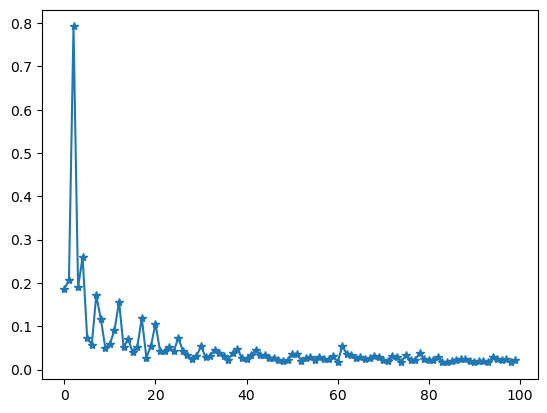

In [ ]:
# k-shot learning on unseen task wrt 50 epochs per shot
test_loss = np.zeros(100)

for i in range(100):
    sample_idx = rng.choice(len(x_test), size=i+1)
    xtest_plot = x_test[sample_idx]
    ytest_plot = y_test[sample_idx]

    optimizer = tf.keras.optimizers.Adam()

    weights_before = deepcopy(model.get_weights())

    # predict after 0 step
    test_loss[0] = compute_loss(x_test, y_test, model)

    # k-shot learning with N epochs
    for inneriter in range(50):
        train_on_batch(xtest_plot, ytest_plot, model, optimizer)

    test_loss[i] = compute_loss(x_test, y_test, model)
    print(test_loss[i])

    model.set_weights(weights_before)

plt.plot(test_loss, marker='*')
plt.show()